## Fetch Rewards Machine Learning Take Home Test 

### Name: Sunny Patel

Here is the approach I took with this assessment.

1. **Collect the data**
2. **Analyze the data**
3. **Split the data into training and test sets**
4. **Normalize the data**
5. **Build neural network architecture** (this could have been done with linear regression, but I decided to go with a neural net)
6. **Train the model** using training data
7. **Evaluate the model**
8. **Tune the model's hyperparameters**
9. **Save the model for future inference**

In [702]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim

In [703]:
df = pd.read_csv('data_daily.csv') # Turn data into pandas dataframe

# Group the data into months since we are trying to predict future months, not days.
df['# Date'] = pd.to_datetime(df['# Date'])
df['Month'] = df['# Date'].dt.to_period('M')
df_monthly = df.groupby('Month')['Receipt_Count'].sum().reset_index()
df_monthly['Month'] = df_monthly['Month'].dt.month
df_monthly

,Month,Receipt_Count
0,1,236736687
1,2,220033460
2,3,248608625
3,4,250644830
4,5,263151748
5,6,260656840
6,7,274776003
7,8,283943231
8,9,281146154
9,10,295965185


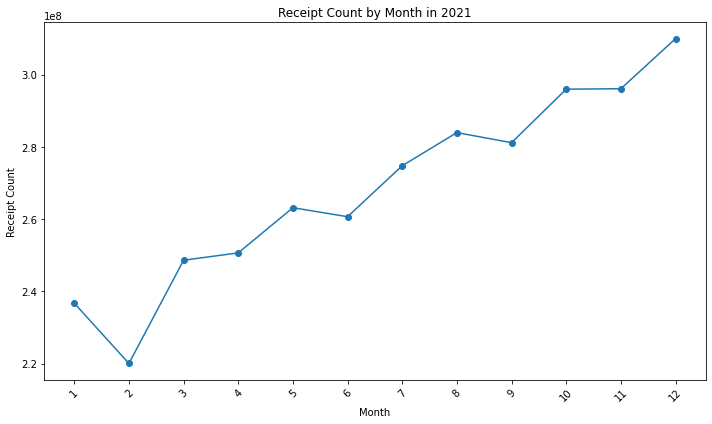

count    3.650000e+02
mean     8.826566e+06
std      7.820089e+05
min      7.095414e+06
25%      8.142874e+06
50%      8.799249e+06
75%      9.476970e+06
max      1.073886e+07
Name: Receipt_Count, dtype: float64

In [704]:
# This shows a very clear linear trend upwards
plt.figure(figsize=(10, 6))
plt.plot(df_monthly['Month'].astype(str), df_monthly['Receipt_Count'], marker='o')

plt.xlabel('Month')
plt.ylabel('Receipt Count')
plt.title('Receipt Count by Month in 2021')
plt.xticks(rotation=45) 
plt.tight_layout()
plt.show()
df["Receipt_Count"].describe()


In [705]:
# Split data; 85% is training, 15% is testing.
# We are splitting the data first to avoid data leakage.
# If we scale then split, we are using information from the test data to train our NN, which is not good.
# This is giving the NN an unfair advantage during the training process, and doesn't reflect realistic inference capabilities.
split_index = int(len(df_monthly) * 0.85)
X_train_original = df_monthly[:split_index]["Month"].to_numpy()
y_train_original = df_monthly[:split_index]["Receipt_Count"].to_numpy()
X_test = df_monthly[split_index:]["Month"].to_numpy()
y_test = df_monthly[split_index:]["Receipt_Count"].to_numpy()


In [706]:
# MinMax scale the data (MinMax scaling is simple so I didn't make a seperate function for it).
# Fit the scaler on the training data alone and fit the testing data using that scaler.
# This would be easier and less code if I could use sk-learn, but I refrained from doing so as per the instructions.
X_train = (X_train_original - X_train_original.min()) / (X_train_original.max() - X_train_original.min())
y_train = (y_train_original - y_train_original.min()) / (y_train_original.max() - y_train_original.min())
X_test = (X_test - X_train_original.min()) / (X_train_original.max() - X_train_original.min())
y_test = (y_test - y_train_original.min()) / (y_train_original.max() - y_train_original.min())

X_train.shape, y_train.shape, X_test.shape, y_test.shape

((10,), (10,), (2,), (2,))

In [707]:
# Convert the data into tensors for PyTorch to use.
X_train_tensor = torch.tensor(X_train, dtype=torch.float32).view(-1, 1)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32).view(-1, 1)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).view(-1, 1)

In [708]:
# Neural network architecture 
# 1 input layer, 1 hidden layer, and 1 output layer
class NeuralNet(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(NeuralNet, self).__init__()
        self.fc_layer1 = nn.Linear(input_dim, hidden_dim)    # Input layer to hidden layer
        self.fc_layer2 = nn.Linear(hidden_dim, output_dim)    # Hidden layer to output layer

    def forward(self, x):
        x = torch.relu(self.fc_layer1(x))   # Activation function for the hidden layer
        x = self.fc_layer2(x)               # Output layer
        return x

torch.manual_seed(42) # Random seed for reproduceability
model = NeuralNet(1, 12, 1) 
criterion = nn.MSELoss()  # Mean Squared Error Loss
optimizer = optim.Adam(model.parameters(), lr=0.005)  # Adam optimizer

In [709]:
# Training process
prev_losses = [] # Keep track of losses over each epoch

num_epochs = 300
for epoch in range(num_epochs):
    model.train()
    
    outputs = model(X_train_tensor)
    loss = criterion(outputs, y_train_tensor)
    prev_losses.append(loss.item())
    
    optimizer.zero_grad()  
    loss.backward()       
    optimizer.step()     
    
    if (epoch+1) % 50 == 0 or epoch == 0:  # Print loss every 10 epochs + the first epoch
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

Epoch [1/300], Loss: 1.1283
Epoch [50/300], Loss: 0.0476
Epoch [100/300], Loss: 0.0203
Epoch [150/300], Loss: 0.0105
Epoch [200/300], Loss: 0.0075
Epoch [250/300], Loss: 0.0071
Epoch [300/300], Loss: 0.0069


In [710]:
# Evaluate the model using our test data (last 2 data points in this case)
model.eval()
with torch.no_grad():
    test_outputs = model(X_test_tensor)
    test_loss = criterion(test_outputs, y_test_tensor)
    
print(f'Test Loss: {test_loss.item():.4f}')

# The test loss is slightly lower than the training loss, which is uncommon but not a deal breaker. 
# This can be bad if it is a result of your testing data leaking into the training process, but I doubt that is the case here.
# Overall, I think this is fine. 

Test Loss: 0.0059


In [711]:
# Making numpy array representing the next 12 months (2022).
next_12_months = np.arange(13, 25) 

# Scaling the next 12 months values using the training dataset.
# Reminder: We are using the training dataset to scale because that is what we scaled the entire dataset with originally to avoid data leakage.
min_value, max_value = X_train_original.min(), X_train_original.max()
next_12_months_scaled = (next_12_months - min_value) / (max_value - min_value)

# Convert into tensor for PyTorch to use.
next_12_months_scaled = torch.tensor(next_12_months_scaled, dtype=torch.float32).view(-1, 1)

# Set the model to evaluation mode.
model.eval()

# Make predictions for 2022
with torch.no_grad():
    predictions = model(next_12_months_scaled)
    
# Predictions for every month of the following year (2022).   
predictions = predictions.flatten().numpy()

# 'Unscale' the predictions; turn them into actual receipt counts. 
receipts_min, receipts_max = y_train_original.min(), y_train_original.max()
predictions = (predictions) * (receipts_max - receipts_min) + receipts_min

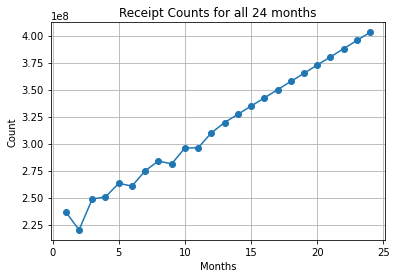

In [712]:
# This graph shows the 12 months in our dataset and their receipt counts + the 12 months we predicted and their estimated counts.
# This is actually a solid line and seems like a good fit, so I'm going to use this model. 

total = df_monthly["Receipt_Count"].to_list() + list(predictions.astype(int))
x_values = np.arange(1, 25)
plt.plot(x_values, total, marker='o')
plt.xlabel('Months')
plt.ylabel('Count')
plt.title('Receipt Counts for all 24 months')
plt.grid(True)
plt.show()


In [713]:
model_path = "./model.pt"

# Scaler information to use for inference.
scaler_params = {
    "X_min": X_train_original.min(), 
    "X_max": X_train_original.max(),
    "y_min": y_train_original.min(),
    "y_max": y_train_original.max()
}

# To perform inference, we save the weights and scaler into a .pt file.
torch.save({
    'model_state_dict': model.state_dict(),
    'scaler_params': scaler_params
}, model_path)